# Project description

Analyst team of a big online store are testing a list of hypotheses that may help the store to boost its revenue.

The goal of this project is to prioritize these hypotheses, launch an A/B test, and analyze the results.

Outline of analysis:
- prioritize hypotheses using RICE/ICE frameworks.
- calculate cumulative revenue by group.
- calculate cumulative average order size by group and relative difference in cumulative average order size.
- calculate each group's conversion rate.
- filter the data from outliers.

Data description:
- hypotheses  description and evaluation dataframe.
- orders with date, order id ,user id, group and amount spent.
- visitors with date, group and number of visitors.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import scipy.stats as stats

pd.set_option("display.max_colwidth", -1)
warnings.simplefilter(action='ignore')

## Prioritizing Hypotheses
* Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
* Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
* Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

In [2]:
hypotheses = pd.read_csv("/datasets/hypotheses_us.csv", sep=';')

hypotheses['ICE'] = (hypotheses.Impact*hypotheses.Confidence)/hypotheses.Effort
hypotheses['RICE'] = (hypotheses.Impact*hypotheses.Confidence*hypotheses.Reach)/hypotheses.Effort

print("ICE framework to prioritize hypotheses:")
print(hypotheses[['Hypothesis','ICE']].sort_values('ICE',ascending=False).head(4).round())
print("\nRICE framework to prioritize hypotheses:")
print(hypotheses[['Hypothesis','RICE']].sort_values('RICE',ascending=False).head(4))
print("\nCompare frameworks:")
display(hypotheses[['Hypothesis','RICE','ICE']].sort_values('RICE',ascending=False))

ICE framework to prioritize hypotheses:
                                                                                 Hypothesis  \
8  Launch a promotion that gives users discounts on their birthdays                           
0  Add two new channels for attracting traffic. This will bring 30% more users                
7  Add a subscription form to all the main pages. This will help you compile a mailing list   
6  Show banners with current offers and sales on the main page. This will boost conversion    

    ICE  
8  16.0  
0  13.0  
7  11.0  
6  8.0   

RICE framework to prioritize hypotheses:
                                                                                                       Hypothesis  \
7  Add a subscription form to all the main pages. This will help you compile a mailing list                         
2  Add product recommendation blocks to the store's site. This will increase conversion and average purchase size   
0  Add two new channels for attracting tr

,Hypothesis,RICE,ICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0,11.200000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0,7.000000
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0,13.333333
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0,8.000000
8,Launch a promotion that gives users discounts on their birthdays,16.2,16.200000
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0,1.125000
1,Launch your own delivery service. This will shorten delivery time,4.0,2.000000
5,Add a customer review page. This will increase the number of orders,4.0,1.333333
4,Change the background color on the main page. This will increase user engagement,3.0,1.000000


* The reason for the change between the frameworks is the additional reach parameter that exist in the RICE framework.

## Part 2. A/B Test Analysis

In [3]:
orders = pd.read_csv("/datasets/orders_us.csv",parse_dates=['date'])
visits = pd.read_csv("/datasets/visits_us.csv",parse_dates=['date'])

print(orders.info())
print(orders.head())
print("")
print(visits.info())
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB
None
   transactionId   visitorId       date  revenue group
0  3667963787     3312258926 2019-08-15  30.4     B   
1  2804400009     3642806036 2019-08-15  15.2     B   
2  2961555356     4069496402 2019-08-15  10.2     A   
3  3797467345     1196621759 2019-08-15  155.1    B   
4  2282983706     2322279887 2019-08-15  40.5     B   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
        d

In [4]:
visitorIdA = orders[orders.group == 'A'].groupby('visitorId').group.max().reset_index()
visitorIdB = orders[orders.group == 'B' ].groupby('visitorId').group.max().reset_index()

dupliuser = visitorIdA.merge(visitorIdB, left_on='visitorId', right_on='visitorId', how='inner')
orders = orders.query('visitorId not in @dupliuser.visitorId')
print("We have {:} users that are both in group A and B.".format(len(dupliuser.visitorId)))

We have 58 users that are both in group A and B.


* To increase the test accuracy I will drop the duplicate users.

In [5]:
datesGroups = orders[['date','group']].drop_duplicates() 

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(
    orders['date'] <= x['date'], orders['group'] == x['group']
    )].agg({'date':'max','group':'max','transactionId':pd.Series.nunique,
            'visitorId':pd.Series.nunique,'revenue':'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(
    visits['date'] <= x['date'], visits['group'] == x['group'])
    ].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


#### Graph cumulative revenue by group. Make conclusions and conjectures.

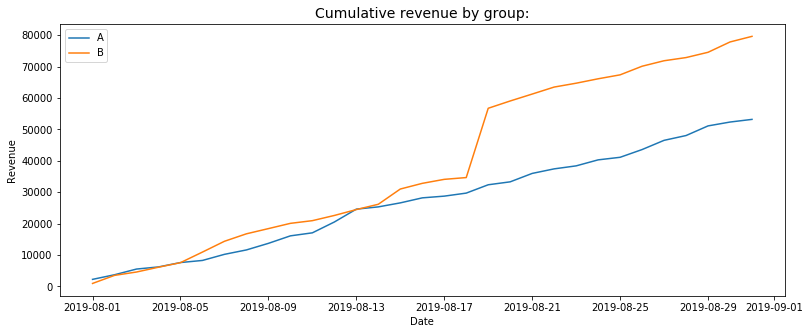

In [6]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Cumulative revenue by group:', size=14)
plt.xlabel("Date", size=10)
plt.ylabel('Revenue', size=10)
plt.legend();

* Cumulative revenue trend is simular in groups A and B. In 19-08-2019 there is big purchase in group B.

#### Graph cumulative average order size by group. Make conclusions and conjectures.

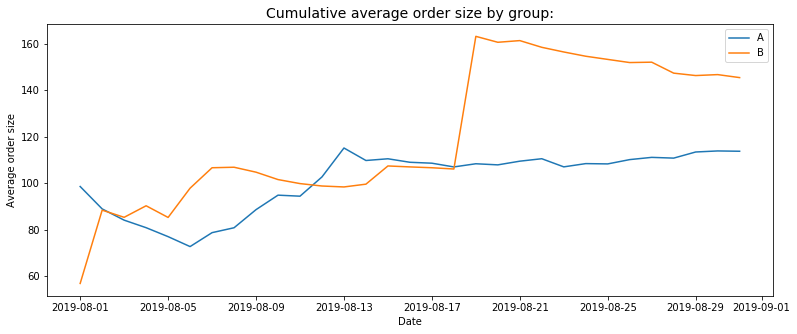

In [7]:
plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Cumulative average order size by group:', size=14)
plt.xlabel("Date", size=10)
plt.ylabel('Average order size', size=10)
plt.legend();

* Cumulative average order size trend is simular in groups A and B. In 19-08-2019 there is big purchase in group B.

#### Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

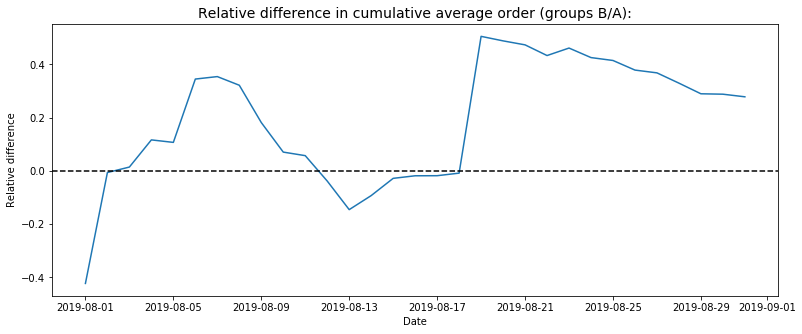

In [8]:
plt.figure(figsize=(13, 5))
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative difference in cumulative average order (groups B/A):', size=14)
plt.xlabel("Date", size=10)
plt.ylabel('Relative difference', size=10);

* The relative difference in cumulative average order is still noisy,probably due to large purchases outliers.

#### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

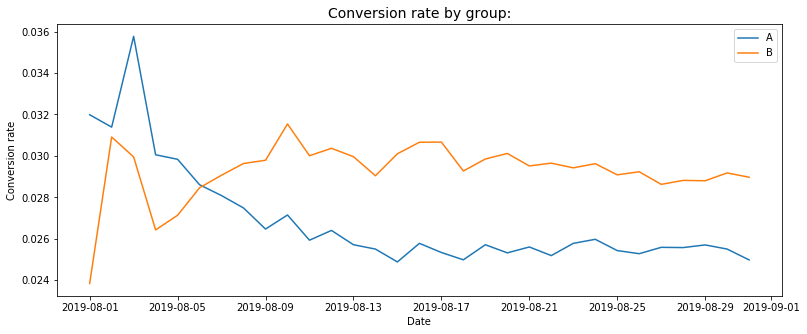

In [9]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(13, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Conversion rate by group:', size=14)
plt.xlabel("Date", size=10)
plt.ylabel('Conversion rate', size=10)
plt.legend();

* conversion rates are steady for groups A and B, and are higher on average in group B.

#### Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

Number of orders per user:
   ordersPerUser  users
0  1              937  
1  2              29   
2  3              7    


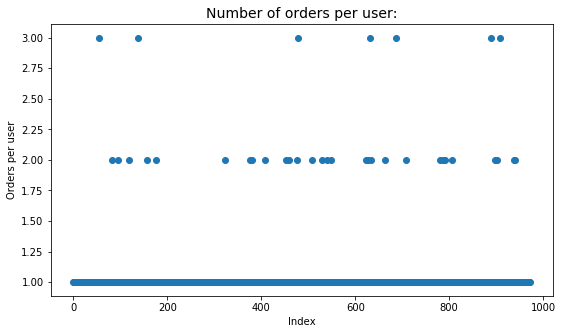

In [10]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsers.columns = ['userId', 'orders']

numberOrdersByUsers = ordersByUsers.orders.value_counts().reset_index()
numberOrdersByUsers.columns = ['ordersPerUser', 'users']
print("Number of orders per user:")
print(numberOrdersByUsers)

plt.figure(figsize=(9, 5))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Number of orders per user:', size=14)
plt.xlabel("Index", size=10)
plt.ylabel('Orders per user', size=10);

* We can see that most of our users making 1 order.

##### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [11]:
print("The 95th percentiles for the number of orders per user is:",(np.percentile(ordersByUsers['orders'], 95)))
print("The 99th percentiles for the number of orders per user is:",(np.percentile(ordersByUsers['orders'], 99)))

The 95th percentiles for the number of orders per user is: 1.0
The 99th percentiles for the number of orders per user is: 2.0


Only 5% of users placed more than 1 orders, more than 1 orders per user is an anomaly.

#### Plot a scatter chart of order prices. Make conclusions and conjectures.

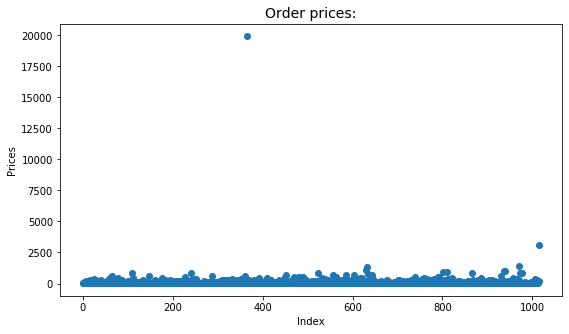

In [12]:
plt.figure(figsize=(9, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Order prices:', size=14)
plt.xlabel("Index", size=10)
plt.ylabel('Prices', size=10);

* Only 2 orders cost more than 2500.

#### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [13]:
print("The 95th percentiles for the number of orders per user is:",round(np.percentile(orders['revenue'], 95)))
print("The 99th percentiles for the number of orders per user is:",round(np.percentile(orders['revenue'], 99)))

The 95th percentiles for the number of orders per user is: 414
The 99th percentiles for the number of orders per user is: 830


Only 5% of orders cost more than 414, spending more than 414 on a single order is an anomaly. 

#### Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

In [14]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("Conversion comparison between groups A and B:")
print("p-value:              {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("B average /A average: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

Conversion comparison between groups A and B:
p-value:              0.006
B average /A average: 0.160


* The p-value is smaller than alpha=0.05 so there is a significant difference in conversion between the groups. Group B have on average higher conversion rates.

#### Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

In [15]:
print("Average order size comparison between groups A and B:")
print('p-value:              {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('B average /A average: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Average order size comparison between groups A and B:
p-value:              0.431
B average /A average: 0.278


* The p-value is greater than alpha=0.05 so there is no significant difference in order size between the groups. 
* Group B have on average larger order sizes.

#### Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

In [16]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 1]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 414]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0
                         ).drop_duplicates().sort_values()

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(
    abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[
    visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(
    abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[
    visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

print("Conversion comparison between groups A and B:")
print("p-value:              {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("B average /A average: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Conversion comparison between groups A and B:
p-value:              0.008
B average /A average: 0.174


* As before  p-value is smaller than alpha=0.05 and didnt change much. 
* The average conversion rates of group B increased by a small margin from 16% to 17% in relation to group A.

#### Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

In [17]:
print("Average order size comparison between filtered A and B:")
print('p-value:              {0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('B average /A average: {0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

Average order size comparison between filtered A and B:
p-value:              0.386
B average /A average: -0.033


* The p-value is greater than alpha=0.05 so there is no significant difference in order size between the groups. 
* The average order size of filtered group A similar to that of filtered group B.

## Conclusions:

* Using ICE we should start with hypotheses no.8: "Launch a promotion that gives users discounts on their birthdays".
* Using RICE we should start with hypotheses no.7: "Add a subscription form to all the main pages. This will help you compile a mailing list".
* We had 58 users that were both in group A and B, we should improve the selection process.
* Both raw and filtered data revealed statistically significance difference in conversion between the groups.
* Neither raw nor filtered data revealed any statistically significant differences in average order size between the groups.
* Raw group B conversion rates are ~16% better than group B conversion rates, and it rises to ~17% in the filtered data.
* There is big spike in the raw group B average order size graph and it seems like they are larger than group A, but after the data is filtered the difference is close to zero.

## Recommendation:
* I will recomend to: (1) Stop the test, consider group B the leader due to better conversion rates.